# Toronto anomalies analysis
Anomalies detection and performance measurement

### Importing necessary libraries

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import utils
import os.path
from __future__ import division
from sklearn import preprocessing

### Loading the data

In [2]:
SITE = 7879
channels = pd.read_csv('../dataset/channels.csv')
channels[channels.siteId == SITE].head()

,siteId,channelId,channelName,units,isCalculated
81434,7879,11723,MP1 BTYVOLT,V,False
81435,7879,11722,MP1 UpDEPTH_1,mm,False
81436,7879,11721,MP1 UNIDEPTH,mm,False
81437,7879,11720,MP1 RAWVEL,m/s,False
81438,7879,11719,MP1 PEAKVEL_1,m/s,False


### Assigning the channelId value to variable

In [3]:
q_raw = 14851
mp1_q_final = 11726
mp1_q_interim = 19495
mp1_flow = 11717

### Using utils to load the values from chosen channels

In [4]:
q_raw = utils.load_channel_data(SITE, q_raw).rename('q_raw').fillna(0)
mp1_q_final = utils.load_channel_data(SITE, mp1_q_final).rename('mp1_q_final').fillna(0)
mp1_q_interim = utils.load_channel_data(SITE, mp1_q_interim).rename('mp1_q_interim').fillna(0)
mp1_flow = utils.load_channel_data(SITE, mp1_flow).rename('mp1_flow').fillna(0)

### Short description of the data

In [5]:
mp1_flow.describe()

count    289582.000000
mean        415.658708
std         136.128093
min           0.000000
25%         330.493172
50%         424.960678
75%         481.294640
max        1798.099976
Name: mp1_flow, dtype: float64

In [6]:
mp1_q_final.describe()

count    258943.000000
mean        451.324441
std         133.677782
min          84.080002
25%         363.100006
50%         464.700012
75%         518.299988
max        1798.500000
Name: mp1_q_final, dtype: float64

### Adding the difference between raw and final

In [7]:
df = pd.concat([mp1_flow, mp1_q_final], axis=1).dropna()
df['q_diff'] = np.abs(df.mp1_q_final - df.mp1_flow)
print('Anomalies in q_raw: {:}'.format(len(df[df['q_diff'] > 1])))

Anomalies in q_raw: 195138


### Creating anomalies data frame

In [8]:
anomalies = df[df.q_diff > 1]
anomalies = anomalies.reset_index()
anomalies[['time','mp1_flow','mp1_q_final','q_diff']].head()

,time,mp1_flow,mp1_q_final,q_diff
0,2015-11-01 00:00:00,265.399994,294.399994,29.000000
1,2015-11-01 00:05:00,271.500000,301.100006,29.600006
2,2015-11-01 00:10:00,273.200012,303.000000,29.799988
3,2015-11-01 00:15:00,272.000000,301.600006,29.600006
4,2015-11-01 00:20:00,263.799988,292.600006,28.800018


### Short description of the anomalies data frame

In [9]:
anomalies.describe()

,mp1_flow,mp1_q_final,q_diff
count,195138.000000,195138.000000,195138.000000
mean,390.286177,437.348421,47.453017
std,108.863560,114.836082,44.394441
min,0.000000,138.500000,1.000610
25%,313.200417,353.600006,33.700012
50%,411.403793,459.100006,45.299988
75%,458.257393,510.200012,50.858910
max,1546.854126,1547.900024,865.116013


### Showing the general plot of given data

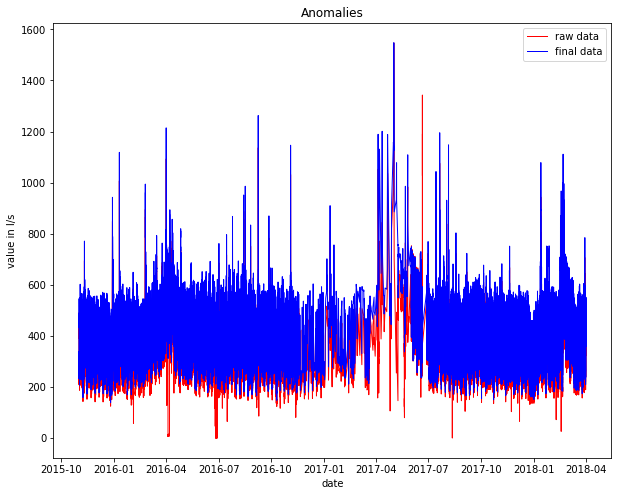

In [10]:
plt.figure(figsize=(10, 8))
plt.plot(anomalies['time'], anomalies['mp1_flow'], color="red",
    label="raw data", linewidth=1)
plt.plot(anomalies['time'], anomalies['mp1_q_final'], c='blue', label="final data",linewidth=1)
plt.xlabel("date")
plt.ylabel("value in l/s")
plt.title("Anomalies")
plt.legend()
plt.show()

### Showing data in a given range

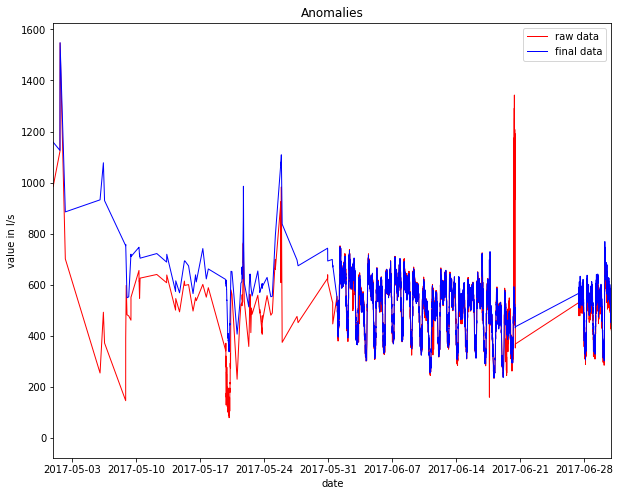

In [115]:
plt.figure(figsize=(10, 8))
plt.plot(anomalies['time'], anomalies['mp1_flow'], color="red",
    label="raw data", linewidth=1)
plt.plot(anomalies['time'], anomalies['mp1_q_final'], c='blue', label="final data",linewidth=1)
plt.xlim(('2017-05-01'),('2017-07-01'))
plt.xlabel("date")
plt.ylabel("value in l/s")
plt.title("Anomalies")
plt.legend()
plt.show()

### Hourly mean of data

In [19]:
data_hour = anomalies
data_hour.head()

,time,mp1_flow,mp1_q_final,q_diff
0,2015-11-01 00:00:00,265.399994,294.399994,29.000000
1,2015-11-01 00:05:00,271.500000,301.100006,29.600006
2,2015-11-01 00:10:00,273.200012,303.000000,29.799988
3,2015-11-01 00:15:00,272.000000,301.600006,29.600006
4,2015-11-01 00:20:00,263.799988,292.600006,28.800018


In [20]:
data_hour['time']=pd.to_datetime(data_hour['time'])

In [21]:
data_hour = data_hour.set_index('time')

In [22]:
data_hour = data_hour.resample('60T').mean()

In [23]:
data_hour = data_hour.reset_index()

In [24]:
data_hour['hour'] = data_hour['time']

In [25]:
data_hour['hour'] = (data_hour['hour'].dt.hour)
data_hour.head()

,time,mp1_flow,mp1_q_final,q_diff,hour
0,2015-11-01 00:00:00,261.091667,289.649999,28.558332,0
1,2015-11-01 01:00:00,251.891668,279.666672,27.775004,1
2,2015-11-01 02:00:00,266.899999,296.183333,29.283334,2
3,2015-11-01 03:00:00,288.874997,320.333333,31.458336,3
4,2015-11-01 04:00:00,259.199998,287.675002,28.475004,4


In [27]:
data_hour[data_hour.isnull().any(axis=1)].head()

,time,mp1_flow,mp1_q_final,q_diff,hour
9180,2016-11-17 12:00:00,NaN,NaN,NaN,12
9181,2016-11-17 13:00:00,NaN,NaN,NaN,13
9182,2016-11-17 14:00:00,NaN,NaN,NaN,14
9183,2016-11-17 15:00:00,NaN,NaN,NaN,15
9184,2016-11-17 16:00:00,NaN,NaN,NaN,16


In [28]:
data_hour = data_hour.dropna(how='any',axis=0) 

In [29]:
data_hour = data_hour[data_hour.mp1_flow != 0]

### Median absolute deviation and standard deviation

In [33]:
x = data_hour['mp1_flow']
y = data_hour['time']

def mad(data, axis=None):
    return np.mean(np.abs(data - np.mean(data, axis)), axis)
_mad = np.abs(x - np.median(x)) / mad(x)

_sd = np.abs(x - np.mean(x)) / np.std(x)

calc = pd.concat([x, y, _mad, _sd], axis=1).dropna()
calc.columns = ['mp1_flow','time','_mad','_sd']

In [34]:
calc.head()

,mp1_flow,time,_mad,_sd
0,261.091667,2015-11-01 00:00:00,1.802535,1.197746
1,251.891668,2015-11-01 01:00:00,1.911370,1.282866
2,266.899999,2015-11-01 02:00:00,1.733822,1.144006
3,288.874997,2015-11-01 03:00:00,1.473860,0.940690
4,259.199998,2015-11-01 04:00:00,1.824913,1.215248


### Showing raw data, median and standard deviation together

Scaling the data

In [44]:
min_max_scaler = preprocessing.MinMaxScaler()
flow_scaled = min_max_scaler.fit_transform(data_hour['mp1_flow'].values.reshape(-1,1))

In [46]:
mad_scaled = min_max_scaler.fit_transform(calc['_mad'].values.reshape(-1,1))

In [47]:
sd_scaled = min_max_scaler.fit_transform(calc['_sd'].values.reshape(-1,1))

Plotting the data,median and standard deviation

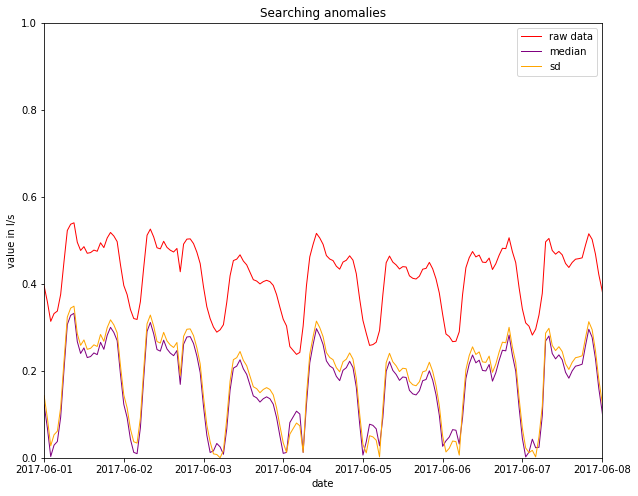

In [112]:
plt.figure(figsize=(10, 8))
plt.plot(data_hour['time'], flow_scaled, color="red",
    label="raw data", linewidth=1)
plt.plot(data_hour['time'], mad_scaled, c='purple', label="median",linewidth=1)
plt.plot(data_hour['time'], sd_scaled, c='orange', label="sd",linewidth=1)
plt.xlim(('2017-06-01'),('2017-06-08'))
plt.ylim(0,1)
plt.xlabel("date")
plt.ylabel("value in l/s")
plt.title("Searching anomalies")
plt.legend()
plt.show()

### Moving average

In [80]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [81]:
x = data_hour['mp1_flow']
y = data_hour['time']

Plotting raw data and moving average

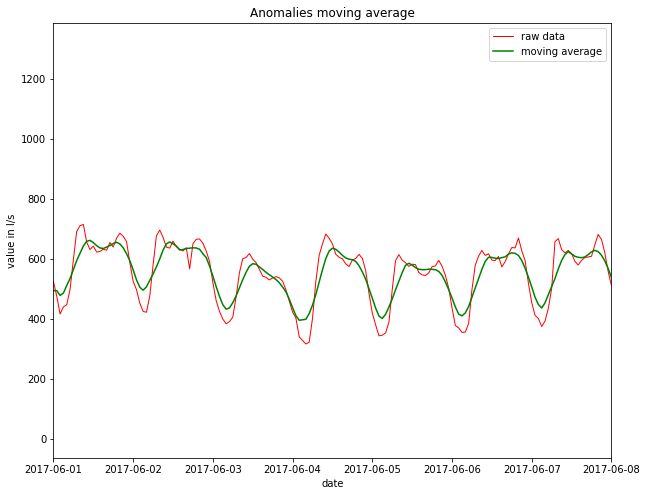

In [113]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)

plt.plot(data_hour['time'], data_hour['mp1_flow'], color="red",
    label="raw data", linewidth=1)
x_av = movingaverage(x,8)

plt.plot(y, x_av, c='green',label="moving average")
plt.xlim(('2017-06-01'),('2017-06-8'))
plt.xlabel("date")
plt.ylabel("value in l/s")
plt.title("Anomalies moving average")
plt.legend()
plt.show()

Plotting raw data, final data and moving average

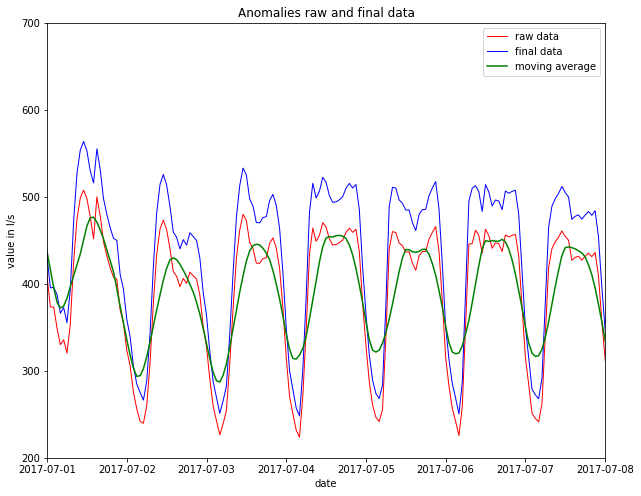

In [114]:
plt.figure(figsize=(10, 8))
plt.plot(data_hour['time'], data_hour['mp1_flow'], color="red",
    label="raw data", linewidth=1)
z_av = movingaverage(x,10)
plt.plot(data_hour['time'], data_hour['mp1_q_final'], c='blue', label="final data",linewidth=1)
plt.plot(y, z_av, c='green',label="moving average")
plt.xlim(('2017-07-01'),('2017-07-8'))
plt.ylim(200,700)
plt.xlabel("date")
plt.ylabel("value in l/s")
plt.title("Anomalies raw and final data")
plt.legend()
plt.show()